In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

X = pd.read_csv("secom.data", sep=" ", header=None)
y = pd.read_csv("secom_labels.data", sep=" ", header=None)[0]
variances = X.var(axis=0, skipna=True)
non_constant_cols = variances[variances > 0].index
X_nc = X[non_constant_cols].copy()
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X_nc)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print("Scaled shape:", X_scaled.shape)
print("Mean (approx 0) of first 5 features:", X_scaled[:, :5].mean(axis=0))
print("Std  (approx 1) of first 5 features:", X_scaled[:, :5].std(axis=0))



Scaled shape: (1567, 474)
Mean (approx 0) of first 5 features: [ 1.62332035e-15 -5.07372631e-15 -5.71336214e-15 -1.26963603e-16
  0.00000000e+00]
Std  (approx 1) of first 5 features: [1. 1. 1. 1. 1.]


step 2

In [2]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, mutual_info_classif


k = 20
start = time.time()
mi_selector = SelectKBest(mutual_info_classif, k=k)
X_mi = mi_selector.fit_transform(X_scaled, y)
end = time.time()
execution_time = end - start
selected_mi_indices = mi_selector.get_support(indices=True)
print("Top 20 MI Feature Indices:", selected_mi_indices)
print(f"MI execution time: {execution_time:.2f} seconds")


rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
k = 20
start = time.time()
rfe = RFE(estimator=rf, n_features_to_select=k, step=1)
rfe.fit(X_scaled, y)
end = time.time()
execution_time = end - start
selected_rfe_indices = np.where(rfe.support_ == True)[0]
print("RFE selected feature indices:", selected_rfe_indices)
print(f"RFE execution time: {execution_time:.2f} seconds")


Top 20 MI Feature Indices: [ 39  51  60 115 121 126 211 230 243 276 328 333 337 348 387 425 455 457
 461 473]
MI execution time: 2.36 seconds


KeyboardInterrupt: 

step 3

In [3]:
k= 20
U, S, VT = np.linalg.svd(X_scaled, full_matrices=False)
V = VT[:k, :]
scores = np.zeros(V.shape[1])
for j in range(V.shape[1]):
    scores[j] = np.sum((S[:k]**2) * (V[:, j]**2))
ranked_indices = np.argsort(scores)[::-1]
top_20_indices = ranked_indices[:20]
print("Top 20 SVD-based feature indices:", top_20_indices)

Top 20 SVD-based feature indices: [317 413 214 315 212 411 140 239 342 412 316 213 281 242 143 284 283 184
 178 389]


step 4

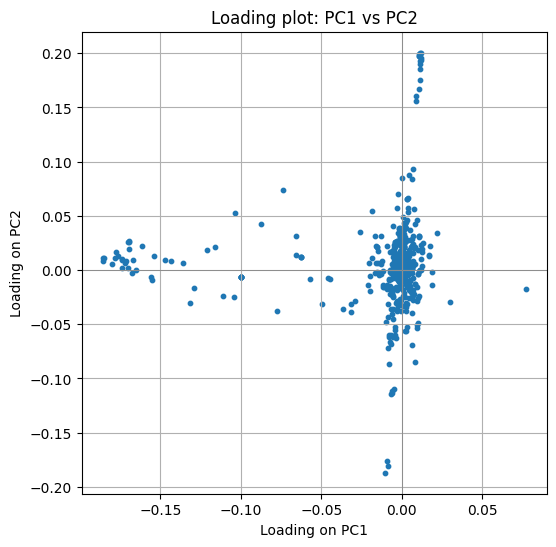

Top 20 SVD-based feature indices (noisy): [317 315 413 214 411 140 212 412 342 239 316 281 213 242 283 143 284 189
 184 389]


KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt

# VT has shape (n_components, n_features)
pc1_loadings = VT[0, :]   # loadings for first component
pc2_loadings = VT[1, :]   # loadings for second component

plt.figure(figsize=(6, 6))
plt.scatter(pc1_loadings, pc2_loadings, s=10)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.xlabel("Loading on PC1")
plt.ylabel("Loading on PC2")
plt.title("Loading plot: PC1 vs PC2")
plt.grid(True)
plt.show()



rng = np.random.default_rng(42)
noise = 0.05 * rng.standard_normal(X_scaled.shape)
X_scaled_noisy = X_scaled + noise

# --- SVD-based ranking on noisy data ---
U_n, S_n, VT_n = np.linalg.svd(X_scaled_noisy, full_matrices=False)
V_n = VT_n[:k, :]
scores_n = np.zeros(V_n.shape[1])
for j in range(V_n.shape[1]):
    scores_n[j] = np.sum((S_n[:k]**2) * (V_n[:, j]**2))
ranked_indices_n = np.argsort(scores_n)[::-1]
top_20_indices_noisy = ranked_indices_n[:20]
print("Top 20 SVD-based feature indices (noisy):", top_20_indices_noisy)


# --- RFE on noisy data ---
start = time.time()
rfe_noisy = RFE(estimator=rf, n_features_to_select=k, step=1)
rfe_noisy.fit(X_scaled_noisy, y)
end = time.time()
selected_rfe_indices_noisy = np.where(rfe_noisy.support_ == True)[0]
print("RFE selected feature indices (noisy):", selected_rfe_indices_noisy)
print(f"RFE (noisy) execution time: {end - start:.2f} seconds")
orig_rfe = set(selected_rfe_indices)
noisy_rfe = set(selected_rfe_indices_noisy)


orig_svd = set(top_20_indices)
noisy_svd = set(top_20_indices_noisy)
intersection_rfe = orig_rfe & noisy_rfe
intersection_svd = orig_svd & noisy_svd
print("RFE overlap:", len(intersection_rfe), "features")
print("SVD overlap:", len(intersection_svd), "features")
print("RFE overlapping indices:", sorted(list(intersection_rfe)))
print("SVD overlapping indices:", sorted(list(intersection_svd)))


step 5

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# example split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# subsets
X_train_mi = X_train[:, selected_mi_indices]
X_test_mi = X_test[:, selected_mi_indices]

X_train_rfe = X_train[:, selected_rfe_indices]
X_test_rfe = X_test[:, selected_rfe_indices]

X_train_svd = X_train[:, top_20_indices]
X_test_svd = X_test[:, top_20_indices]

clf = LogisticRegression(max_iter=1000)

def eval_subset(Xtr, Xte):
    clf.fit(Xtr, y_train)
    y_pred = clf.predict(Xte)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    return acc, f1


acc_mi, f1_mi = eval_subset(X_train_mi, X_test_mi)
acc_rfe, f1_rfe = eval_subset(X_train_rfe, X_test_rfe)
acc_svd, f1_svd = eval_subset(X_train_svd, X_test_svd)
set_rfe = set(selected_rfe_indices)
set_svd = set(top_20_indices)
intersection = set_rfe & set_svd
overlap_count = len(intersection)
overlap_percent_rfe = overlap_count / len(set_rfe) * 100
overlap_percent_svd = overlap_count / len(set_svd) * 100



NameError: name 'selected_rfe_indices' is not defined